In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, seaborn as sns, timeit
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from samplers import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend
from scipy.stats import kde

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Generate some random data:

In [2]:
n_in = 1
n_out = 2

In [3]:
error_sigma2 = 0.1
nobs = 1_000
xtrue = torch.randn(nobs, n_in, requires_grad=True)
xvals = xtrue.data
ytrue = np.zeros((nobs, n_out))
ytrue[:,0] = list(abs(xvals)*np.cos(2*xvals))
ytrue[:,1] = list(abs(xvals)*np.sin(3*xvals))
ytrue = 5*torch.from_numpy(ytrue).float() + torch.randn(nobs,2)*np.sqrt(error_sigma2)
criterion = nn.MSELoss()

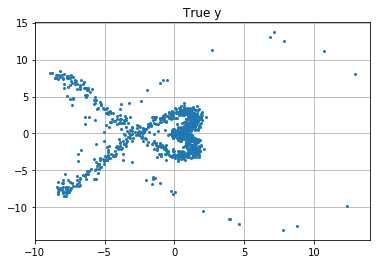

In [4]:
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

#### Set up neural network:

In [5]:
n_h1 = 25
n_h2 = 25
nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_h2),
                         nn.Tanh(),
                         nn.Linear(n_h2, n_out))
init_normal(nn_model)

In [6]:
print("Total number of parameters in neural network is", sum(p.numel() for p in nn_model.parameters()))

Total number of parameters in neural network is 752


### MALA:

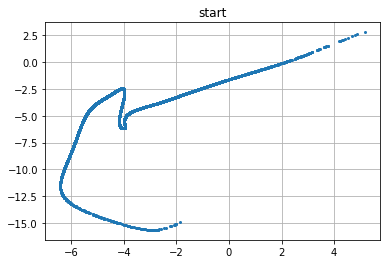

In [7]:
prior_sigma = 1e0
my_model = model(deepcopy(xtrue), deepcopy(ytrue), prior_sigma, error_sigma, deepcopy(nn_model))
my_model.update_grad()
y_initial = my_model.nn_model(my_model.x)
plt.plot(list(y_initial[:,0]), list(y_initial[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start");

In [8]:
Nsteps = 5_000
stepsize = 1.5e-4
mala = MALA(my_model, Nsteps, stepsize)

iter 500/5000 after 1.01 min | accept_rate 100.0 percent | MSE loss 1.744
iter 1000/5000 after 2.05 min | accept_rate 100.0 percent | MSE loss 0.955
iter 1500/5000 after 3.07 min | accept_rate 100.0 percent | MSE loss 0.748
iter 2000/5000 after 4.10 min | accept_rate 100.0 percent | MSE loss 0.657
iter 2500/5000 after 5.15 min | accept_rate 100.0 percent | MSE loss 0.602
iter 3000/5000 after 6.26 min | accept_rate 100.0 percent | MSE loss 0.564
iter 3500/5000 after 7.31 min | accept_rate 100.0 percent | MSE loss 0.536
iter 4000/5000 after 8.43 min | accept_rate 100.0 percent | MSE loss 0.513
iter 4500/5000 after 9.60 min | accept_rate 99.9 percent | MSE loss 0.496
iter 5000/5000 after 10.75 min | accept_rate 99.9 percent | MSE loss 0.481


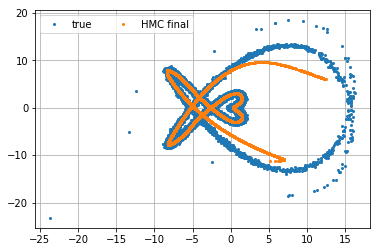

In [98]:
mala.run()
ypred_final = mala.model.nn_model(mala.model.x)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.plot(ypred_final[:,0].data.numpy(), ypred_final[:,1].data.numpy(), 'o', markersize=2, label="HMC final")
plt.grid(True)
plt.legend(ncol=2);

Text(0.5,0,'Iteration')

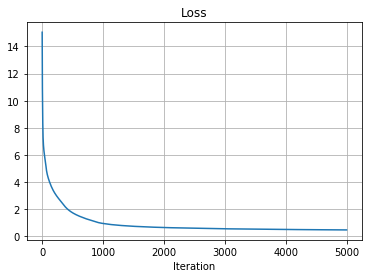

In [99]:
plt.plot(mala.loss)
# plt.yscale('log')
plt.title("Loss")
plt.grid(True)
plt.xlabel("Iteration")

### HMC:

Initial loss = tensor(79.3684)


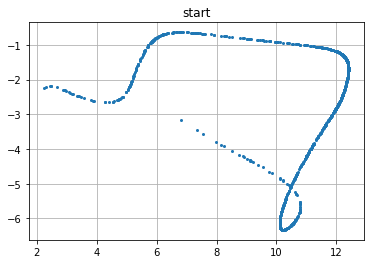

In [40]:
prior_sigma = 1.
my_model = model(deepcopy(xtrue), deepcopy(ytrue), prior_sigma, error_sigma2, deepcopy(nn_model))
my_model.update_grad()
y_initial = my_model.nn_model(my_model.x)
plt.plot(list(y_initial[:,0]), list(y_initial[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start")
print("Initial loss =", nn.MSELoss()(my_model.nn_model(xtrue), ytrue).detach())

In [41]:
Nsteps = 5000
n_leapfrog = 50
stepsize = 1e-3
hmc = HMC(my_model, Nsteps, stepsize, n_leapfrog)

In [ ]:
hmc.run()
ypred_final = hmc.model.nn_model(hmc.model.x)
plt.plot(ypred_final[:,0].data.numpy(), ypred_final[:,1].data.numpy(), 'o', markersize=2, label="HMC final")
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.grid(True)
plt.legend(ncol=2);

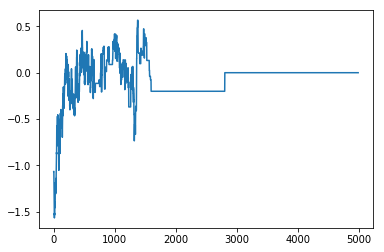

In [38]:
plt.plot(hmc.chain[10:,20].detach().numpy())

Text(0.5,0,'Iteration')

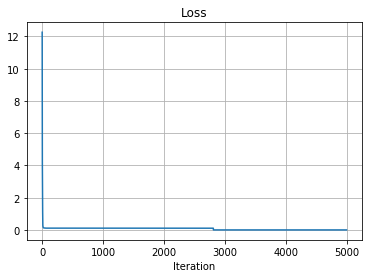

In [39]:
plt.plot(hmc.loss)
# plt.yscale('log')
plt.title("Loss")
plt.grid(True)
plt.xlabel("Iteration")